# Compare spatial patterns
This notebook compares the spatial patterns of a variable at certain timestamps for the coarse data (ERA5), reference data, and the downscaled data.

In [1]:
import os, sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
import xesmf as xe
import xskillscore as xs

from functools import partial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.ticker import FuncFormatter
import glob

import sys
import ast
sys.path.append("../../") 
from src.assess_model import *

In [2]:
RAW_INPUT_PATH = Path("../../data/01-raw/")
INPUT_PATH = Path("../../data/02-processed/")
RESULTS_PATH = Path("../../data/03-results/")
FIGS_PATH = Path("../../figs/")
YEARS = np.arange(2003,2023,1)
VARIABLE = 'tmax'
metrics_columns = ['rmse','mae','binary-accuracy']

RESOLUTION = 0.02
if VARIABLE == 'precip': 
    evaluation_years = [2008,2009,2010,2016,2017,2018]
    VARIABLE_LR = 'tp'
elif VARIABLE in ['tmin', 'tmax']: 
    evaluation_years = [2008,2009,2010,2016]
    VARIABLE_LR = 't2m_min' if VARIABLE=='tmin' else 't2m_max'
    metrics_columns = metrics_columns[:-1]

# Read data

## Read bounds

In [3]:
bounds_df = pd.read_csv(RAW_INPUT_PATH / 'domains' / 'downscaling_domains_fixed.csv')
bounds_df['full_bounds'] = bounds_df['full_bounds'].apply(ast.literal_eval)
bounds_df['focused_bounds'] = bounds_df['focused_bounds'].apply(ast.literal_eval)
bounds_df

,city,full_bounds,focused_bounds
0,Dagupan,"[120.00931049408791, 120.4821769636825, 15.907...","[120.210342, 120.450668, 15.928978, 16.138177]"
1,Palayan,"[120.8625098711998, 121.33347866342953, 15.294...","[121.042557, 121.131134, 15.495371, 15.584679]"
2,MetroManila,"[120.8470354518582, 121.22452516891933, 14.273...","[120.8670354518582, 121.20452516891933, 14.293..."
3,Legazpi,"[123.63316781038878, 123.90749473184147, 12.97...","[123.68657, 123.767166, 13.113921, 13.205771]"
4,Iloilo,"[122.41374050886832, 122.69006942567574, 10.61...","[122.477646, 122.602422, 10.676429, 10.80698]"
5,Mandaue,"[123.773858, 124.048004, 10.209113, 10.476077]","[123.899689, 123.980026, 10.297017, 10.383142]"
6,Tacloban,"[124.8437, 125.11697419235658, 11.119000306165...","[124.94133, 125.04055, 11.151456, 11.283467]"
7,Zamboanga,"[121.85371390413884, 122.48448071157127, 6.812...","[122.013817, 122.199554, 6.852464, 7.015031]"
8,CagayanDeOro,"[124.37435854096319, 124.93891405194286, 8.136...","[124.554405, 124.701691, 8.38679, 8.551884]"
9,Davao,"[125.05176056799016, 125.81579781461177, 6.868...","[125.540085, 125.666771, 7.033772, 7.156422]"


In [4]:
CITY_NAMES = bounds_df['city'].unique()
OUTPUT_CITY_NAMES = ['MetroManila' if city_name in ['Muntinlupa', 'Navotas', 'Mandaluyong'] else city_name for city_name in CITY_NAMES]

## Read shapefiles

In [5]:
brgy_gdf = gpd.read_file(RAW_INPUT_PATH / 'domains' / 'target_admin_boundaries.zip')
brgy_gdf.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((120.34737 16.06009, 120.34761 16.060..."
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((120.34054 16.04489, 120.34054 16.044..."
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((121.12250 15.58028, 121.12687 15.579..."


In [6]:
ph_gdf = gpd.read_file(RAW_INPUT_PATH / 'domains' / 'ph_simplified.gpkg')
ph_gdf.head()

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,Shape_Leng,Shape_Area,ADM2ALT1EN,AREA_SQKM,area,layer,path,geometry
0,Metro Manila,PH13076,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,None,0.933806,0.016492,None,196.722285,197,Dissolved,MultiPolygon?crs=EPSG:4326&field=ADM2_EN:strin...,"MULTIPOLYGON (((119.45860 4.66005, 119.45922 4..."


## Read downscaled model output

In [7]:
output_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    out_ds = xr.load_dataset(RESULTS_PATH / VARIABLE / f"downscaled_{VARIABLE}_{city_name.lower()}_corrected.nc")
    out_ds = out_ds[VARIABLE]
    output_ds_list.update({city_name: out_ds})

## Read reference data

In [8]:
ref_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    ref_ds = xr.load_dataset(INPUT_PATH / "model_input" / f"ref_hr_{city_name.lower()}.nc")
    ref_ds = ref_ds[VARIABLE]
    ref_ds_list.update({city_name: ref_ds})

## Read coarse data

In [9]:
lr_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    lr_ds = xr.load_dataset(INPUT_PATH / "lr_res" / f"era5_{city_name.lower()}.nc")
    lr_ds = lr_ds[VARIABLE_LR]
    lr_ds_list.update({city_name: lr_ds})

## Regrid to compute differences

In [10]:
output_city_name='CagayanDeOro'
shp_city_name = 'Cagayan de Oro City'

In [11]:
output_ds=output_ds_list[output_city_name]
lr_ds=lr_ds_list[output_city_name]
ref_ds=ref_ds_list[output_city_name]
#city_brgy_gdf = brgy_gdf[brgy_gdf['ADM3_EN'].str.upper().str.contains(output_city_name.upper())]
city_brgy_gdf = brgy_gdf[brgy_gdf['ADM3_EN']==shp_city_name]
output_ds=output_ds.sel(time=output_ds.time.dt.year.isin(evaluation_years))
ref_ds=ref_ds.sel(time=ref_ds.time.dt.year.isin(evaluation_years))
lr_ds=lr_ds.sel(time=lr_ds.time.dt.year.isin(evaluation_years))

lon0, lon1, lat0, lat1 = bounds_df[bounds_df['city']==output_city_name]['full_bounds'].values[0]
#Tacloban, Dagupan
lon0 = lon0+1*RESOLUTION
lat0 = lat0+1*RESOLUTION

In [12]:
# Regrid
ds_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat0, lat1, RESOLUTION)),
        "lon": (["lon"], np.arange(lon0, lon1, RESOLUTION)),
    }
)
lr_regridder = xe.Regridder(lr_ds, ds_grid, "nearest_s2d")
lr_regridded_ds = lr_regridder(lr_ds, keep_attrs=True)

ref_regridder = xe.Regridder(ref_ds, ds_grid, "nearest_s2d")
ref_regridded_ds = ref_regridder(ref_ds, keep_attrs=True)

output_regridder = xe.Regridder(output_ds, ds_grid, "nearest_s2d")
output_regridded_ds = output_regridder(output_ds, keep_attrs=True)


### Plot most improved timesteps

In [13]:
diff_output_ref_ds = np.abs(output_regridded_ds - ref_regridded_ds)
diff_output_ref_ds = diff_output_ref_ds.where(ref_regridded_ds.mean(dim=['lat','lon'])>10, drop=True)
mean_diff_output_ref_ds = diff_output_ref_ds.mean(dim=['lat','lon'])
# filter specific months, if needed
#mean_diff_output_ref_ds = mean_diff_output_ref_ds.where(mean_diff_output_ref_ds['time'].dt.month == 9, drop=True)
lowest_errors_idx = mean_diff_output_ref_ds.argsort()[:10].values

# diff_output_ref_ds = output_regridded_ds - ref_regridded_ds
# mean_diff_output_ref_ds = diff_output_ref_ds.mean(dim=['lat','lon'])
# lowest_errors_idx  = mean_diff_output_ref_ds.argsort()[-10:].values

lowest_errors_dates = [mean_diff_output_ref_ds['time'].values[idx] for idx in lowest_errors_idx ]
lowest_errors_dates_str = [mean_diff_output_ref_ds['time'].dt.strftime("%Y-%m-%d").values[idx] for idx in lowest_errors_idx ]
lowest_errors_dates 

[numpy.datetime64('2009-03-19T00:00:00.000000000'),
 numpy.datetime64('2009-03-25T00:00:00.000000000'),
 numpy.datetime64('2009-03-22T00:00:00.000000000'),
 numpy.datetime64('2016-01-05T00:00:00.000000000'),
 numpy.datetime64('2009-03-17T00:00:00.000000000'),
 numpy.datetime64('2016-01-14T00:00:00.000000000'),
 numpy.datetime64('2016-01-20T00:00:00.000000000'),
 numpy.datetime64('2009-03-07T00:00:00.000000000'),
 numpy.datetime64('2016-01-04T00:00:00.000000000'),
 numpy.datetime64('2016-01-06T00:00:00.000000000')]

In [14]:
def format_ticks(value, pos):
    return f"{value:.2f}"

/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_13262/3776955911.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results mig

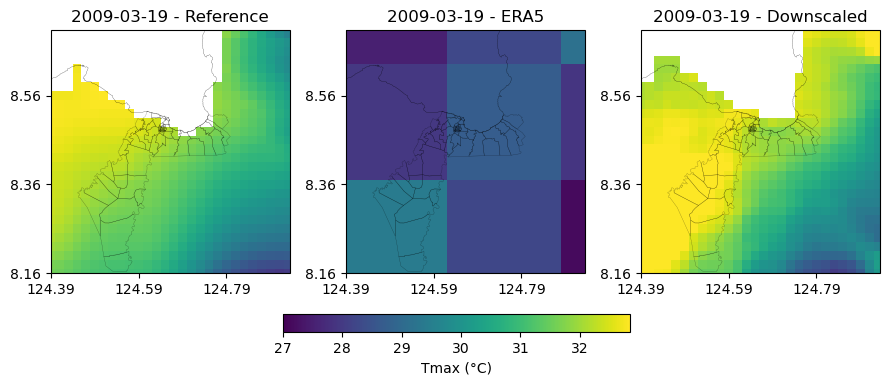

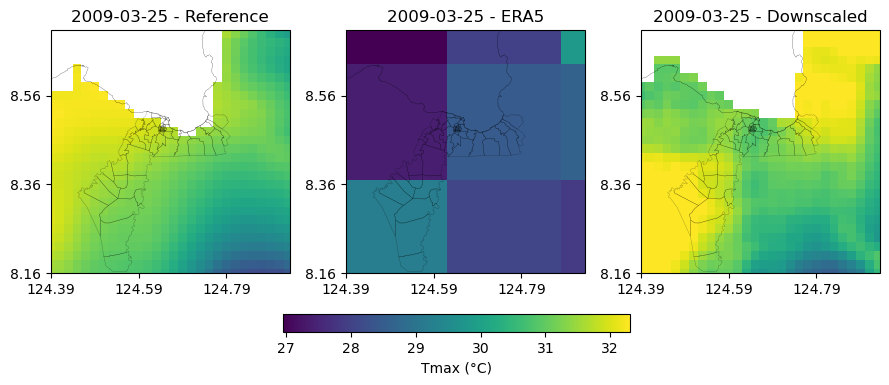

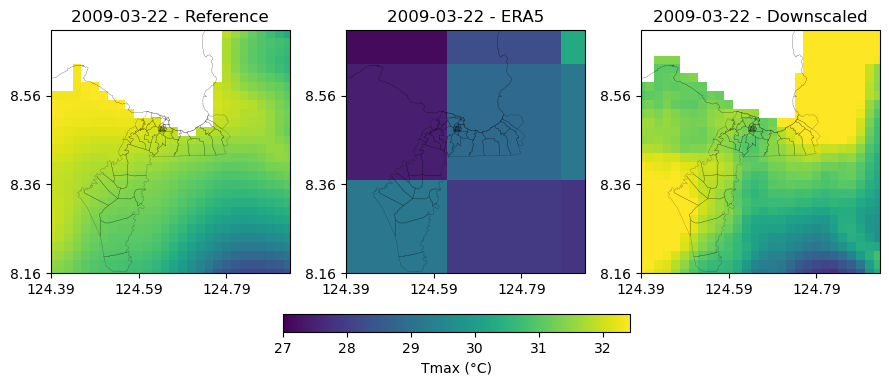

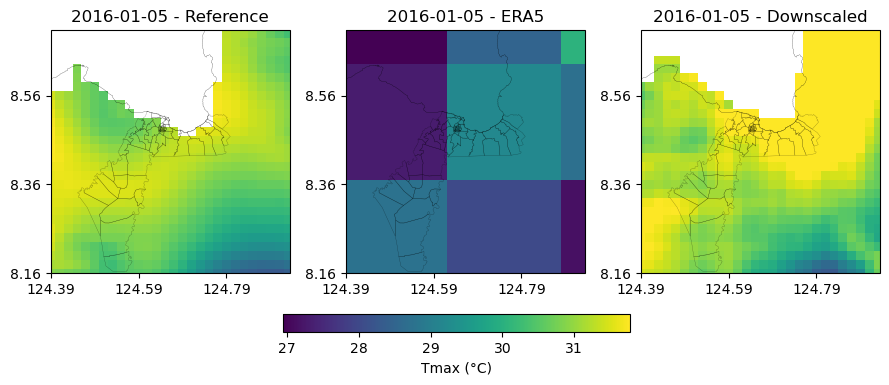

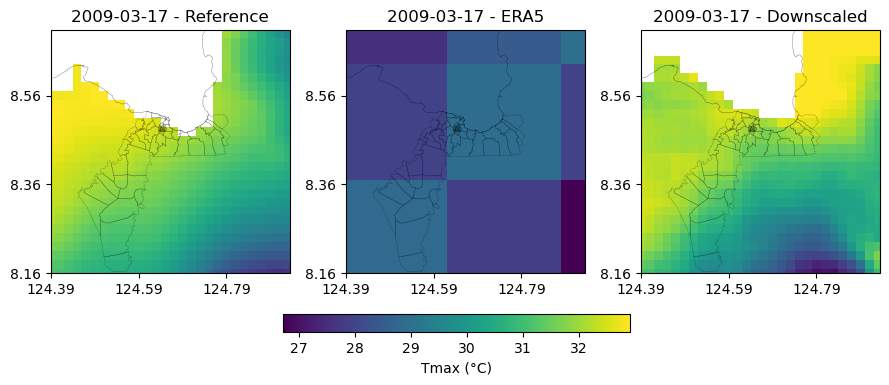

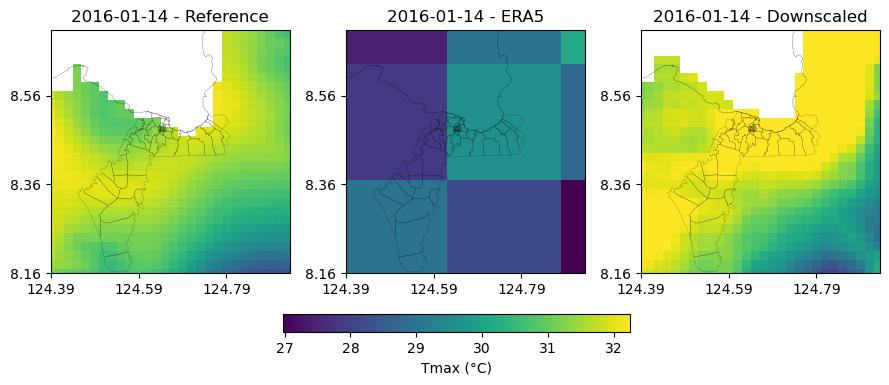

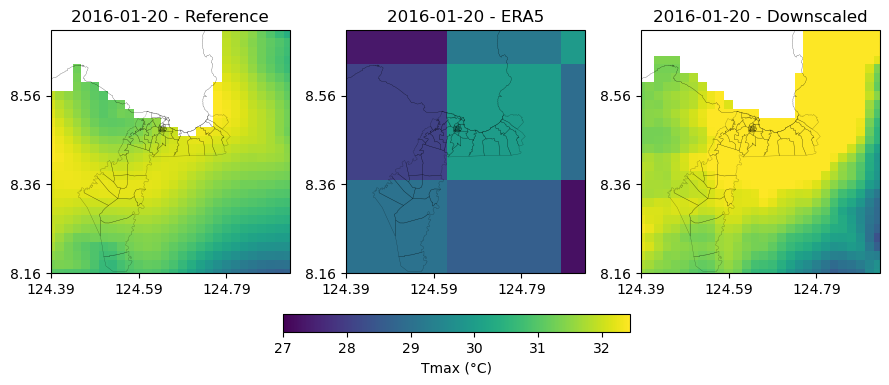

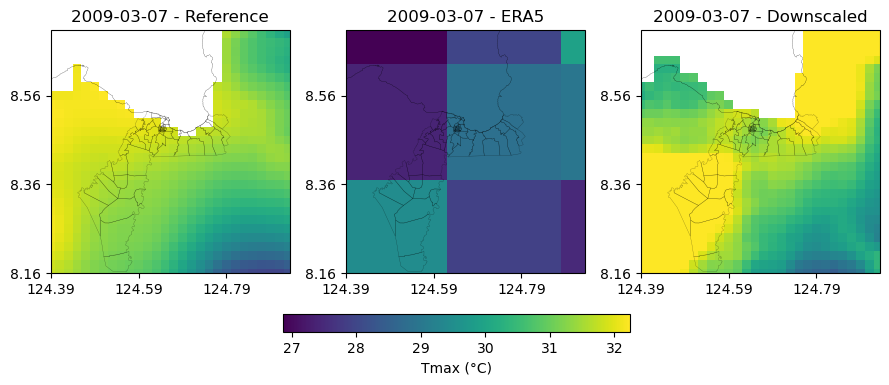

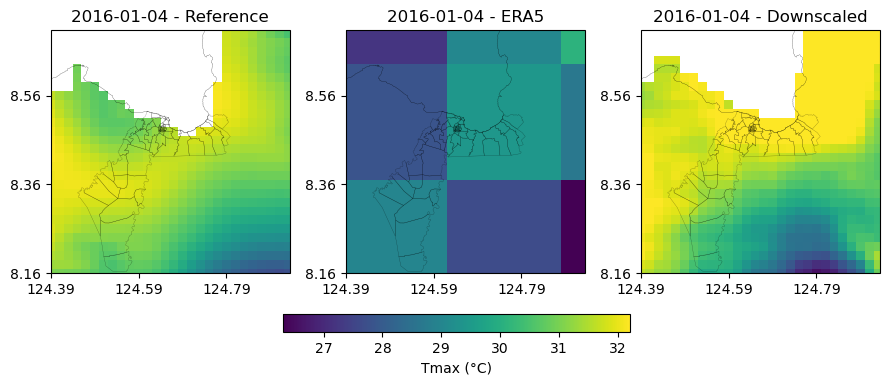

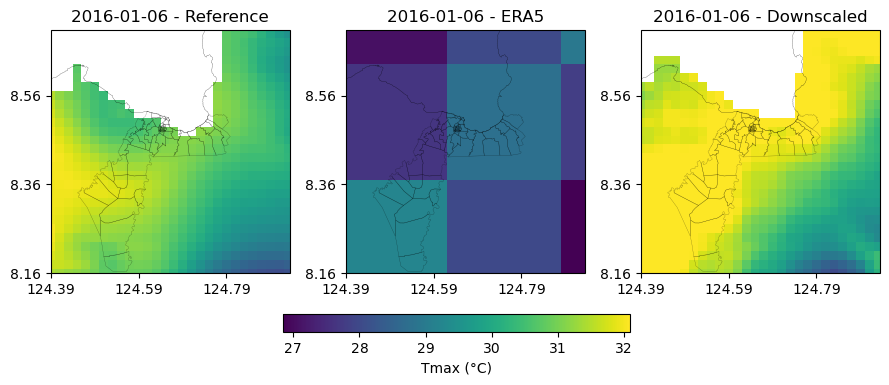

In [15]:
for i in np.arange(len(lowest_errors_dates)):
    data_ref_ds=ref_regridded_ds.sel(time=lowest_errors_dates[i])
    data_lr_ds=lr_regridded_ds.sel(time=lowest_errors_dates[i])
    data_output_ds=output_regridded_ds.sel(time=lowest_errors_dates[i])

    labels = ['Reference','ERA5','Downscaled']
    data_ds = [data_ref_ds,data_lr_ds,data_output_ds]

    vmin = min(27,data_output_ds.min().values, data_lr_ds.min().values, data_ref_ds.min().values)
    vmax = max(27,data_output_ds.min().values, data_lr_ds.max().values, data_ref_ds.max().values)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4.5),subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    for n,ax in enumerate(axes):
        im = data_ds[n].plot(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
        ph_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.2, alpha=0.8)
        city_brgy_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.2, alpha=0.5)

        ax.set_title(f'{lowest_errors_dates_str[i]} - {labels[n]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(np.arange(lon0, lon1, 10*RESOLUTION), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat0, lat1, 10*RESOLUTION), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.set_xlim([lon0, lon1])
        ax.set_ylim([lat0, lat1])

    # Create a single colorbar in the middle of the figure
    cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=-0.25)
    cbar.set_label('Tmax (°C)') #'Rainfall (mm)' 'Tmin (°C)' # Replace with your variable's units or description
    fig.tight_layout()
    fig.savefig(FIGS_PATH / f"{VARIABLE}_{output_city_name}_{lowest_errors_dates_str[i]}_comparison.png", dpi=150)